In [1]:
import pandas as pd
import geopandas as gpd
from fuzzywuzzy import process
import geopandas as gpd
import plotly.express as px

In [2]:
# Load Airbnb, ZHVI, and NYC geo-spatial datasets
airbnb_data = pd.read_csv('assets/Airbnb_Open_Data.csv', low_memory=False)
zhvi_data = pd.read_csv('assets/ZHVI_dataset.csv')
nyc_geo_data = gpd.read_file('assets/nyc_geo_export.shp')

# Drop rows with missing values in the 'neighbourhood' column
airbnb_data.dropna(subset=['neighbourhood'], inplace=True)

# Remove dollar signs and commas from the 'price' column and convert it to float
airbnb_data['price'] = airbnb_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Keep only rows where the 'price' is greater than 0
airbnb_data = airbnb_data[airbnb_data['price'] > 0]

# Drop rows with NaN values in the “review rate number” column
airbnb_data.dropna(subset=['review rate number'], inplace=True)

# Convert rate number to int
airbnb_data['review rate number'] = airbnb_data['review rate number'].astype(int)
                                                                  
# Drop rows with missing values in the 'RegionName' column
zhvi_data.dropna(subset=['RegionName'], inplace=True)

# Create a new DataFrame 'ny_zhvi_data' that contains only rows where the 'City' column is 'New York'
ny_zhvi_data = zhvi_data[zhvi_data['City'] == 'New York'].copy()

#### Neighborhood Analysis
#### Standardizing Neighborhood Names
Standardizes neighborhood names across datasets by identifying discrepancies, applying fuzzy matching to find best matches, and creating a rename map for correction. It then updates the names in the datasets, prints the rename map, and outputs the number of discrepancies before and after standardization for analysis.

In [3]:
# Function to find discrepancies between two sets of neighbourhood names
def find_discrepancies(source_names, target_names):
    discrepancies = [value for value in source_names if value not in target_names]
    return discrepancies

# Function to normalize neighbourhood names for consistency
def normalize_names(names):
    return {name.strip().lower() for name in names}

# Function to find the best matching name for discrepancies using fuzzy matching
def find_best_matches(discrepancies, target_names):
    """
    For each discrepancy name, it searches for the best match within a reference set of names 
    key: orginial discrepancy name
    value: best matching name found in reference set
    """
    original_form = {name.strip().lower(): name for name in target_names}
    matches = {}
    for name in discrepancies:
        best_match = process.extractOne(name, original_form.keys(), score_cutoff=90)
        if best_match:
            matches[name] = original_form[best_match[0]]
    return matches

# Normalize names in all datasets
airbnb_names = normalize_names(airbnb_data['neighbourhood'].unique())
zhvi_names = normalize_names(ny_zhvi_data['RegionName'].unique())
nyc_names = normalize_names(nyc_geo_data['name'].unique())

# Identify discrepancies after initial normalization
discrepancies_airbnb = find_discrepancies(airbnb_names, nyc_names)
discrepancies_zhvi = find_discrepancies(zhvi_names, nyc_names)

# Find best matches for discrepancies
matches_airbnb = find_best_matches(discrepancies_airbnb, nyc_names)
matches_zhvi = find_best_matches(discrepancies_zhvi, nyc_names)

# Create a rename map for correcting names in the datasets
rename_map = {**matches_airbnb, **matches_zhvi}

# Apply rename map to correct neighbourhood names
airbnb_data['neighbourhood'] = airbnb_data['neighbourhood'].apply(lambda x: rename_map.get(x.strip().lower(), x))
ny_zhvi_data['RegionName'] = ny_zhvi_data['RegionName'].apply(lambda x: rename_map.get(x.strip().lower(), x))

# Re-identify unique neighbourhoods and discrepancies after name corrections
airbnb_names_updated = normalize_names(airbnb_data['neighbourhood'].unique())
zhvi_names_updated = normalize_names(ny_zhvi_data['RegionName'].unique())


discrepancies_airbnb_updated = find_discrepancies(airbnb_names_updated, nyc_names)
discrepancies_zhvi_updated = find_discrepancies(zhvi_names_updated, nyc_names)

# Print the rename map for correcting names in the datasets
print("Rename Map:")
for original_name, corrected_name in rename_map.items():
    print(f"Original: {original_name} -> Corrected: {corrected_name}")

# Output the number of discrepancies after standardizing names
print("Dataset Discrepancies")
print(f"\nInitial Airbnb Discrepancies: {len(discrepancies_airbnb)} Updated: {len(discrepancies_airbnb_updated)}")
print(f"Initial ZHVI Discrepancies: {len(discrepancies_zhvi)} Updated: {len(discrepancies_zhvi_updated)}")

Rename Map:
Original: bull's head -> Corrected: bulls head
Original: east morrisania -> Corrected: morrisania
Original: ditmars steinway -> Corrected: steinway
Original: jamaica -> Corrected: south jamaica
Original: tremont -> Corrected: east tremont
Original: prospect-lefferts gardens -> Corrected: prospect lefferts gardens
Original: highbridge -> Corrected: high  bridge
Original: flatiron district -> Corrected: flatiron
Original: bay terrace, staten island -> Corrected: bay terrace
Original: corona -> Corrected: south corona
Original: chelsea, staten island -> Corrected: chelsea
Original: downtown brooklyn -> Corrected: downtown
Original: mariners harbor -> Corrected: mariner's harbor
Original: richmondtown -> Corrected: richmond town
Original: bedford-stuyvesant -> Corrected: bedford stuyvesant
Original: flushing -> Corrected: downtown flushing
Original: harlem -> Corrected: east harlem
Original: throggs neck -> Corrected: throgs neck
Original: battery park -> Corrected: battery par

Yearly Analysis


In [4]:
# Convert 'last review' column to datetime format
airbnb_data['last review'] = pd.to_datetime(airbnb_data['last review'], errors='coerce')

# Extract the year from the 'last review' column and create a new column 'last_review_year'
airbnb_data['last_review_year'] = airbnb_data['last review'].dt.year

fig = px.histogram(airbnb_data, x='last_review_year',
                   title='Histogram of Reviews by Year',
                   labels={'last_review_year': 'Year', 'count': 'Number of Reviews'})


fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Number of Reviews'),
    showlegend=False
)

In [10]:
# Define the valid year range
valid_year_range = (2019, 2023)

# Filter the DataFrame to keep only rows with valid years
airbnb_data_filtered = airbnb_data[
    (airbnb_data['last_review_year'] >= valid_year_range[0]) &
    (airbnb_data['last_review_year'] <= valid_year_range[1])
]
airbnb_data_filtered.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license,last_review_year
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,10.0,9.0,2021-10-19,0.21,4,6.0,286.0,Clean up and treat the home the way you'd like...,NaN,2021.0
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,30.0,45.0,2022-05-21,0.38,4,2.0,228.0,Pet friendly but please confirm with me if the...,NaN,2022.0
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,30.0,270.0,2019-07-05,4.64,4,1.0,322.0,NaN,NaN,2019.0
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,3.0,74.0,2019-06-22,0.59,3,1.0,374.0,"No smoking, please, and no drugs.",NaN,2019.0
8,1005754,Large Furnished Room Near B'way,79384379533,verified,Evelyn,Manhattan,Hell's Kitchen,40.76489,-73.98493,United States,...,2.0,430.0,2019-06-24,3.47,3,1.0,180.0,- Please clean up after yourself when using th...,NaN,2019.0


In [5]:
# Filter Zillow DataFrame for last 5 years 
last_five_years = ny_zhvi_data.columns[-60:]  
zhvi_data_filtered = ny_zhvi_data[['RegionName'] + list(last_five_years)]
zhvi_data_filtered

,RegionName,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,...,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023,12/31/2023
2,Upper West Side,1.475808e+06,1.446622e+06,1.409703e+06,1.389642e+06,1.379921e+06,1.380592e+06,1.389864e+06,1.392304e+06,1.387408e+06,...,1.333659e+06,1.319181e+06,1.312394e+06,1.306469e+06,1.300068e+06,1.290134e+06,1.279944e+06,1.268694e+06,1.256646e+06,1.249004e+06
3,Upper East Side,1.494759e+06,1.471235e+06,1.443590e+06,1.427194e+06,1.418291e+06,1.418033e+06,1.424390e+06,1.424955e+06,1.416624e+06,...,1.299309e+06,1.280345e+06,1.271159e+06,1.265537e+06,1.261153e+06,1.256656e+06,1.252097e+06,1.243821e+06,1.232594e+06,1.222273e+06
6,East New York,4.676254e+05,4.759620e+05,4.859521e+05,4.937017e+05,4.990822e+05,5.048359e+05,5.102145e+05,5.155336e+05,5.192860e+05,...,5.777697e+05,5.812361e+05,5.882919e+05,5.939426e+05,5.965929e+05,5.975904e+05,5.990324e+05,5.995893e+05,5.997741e+05,6.012078e+05
7,bedford stuyvesant,8.594544e+05,8.610864e+05,8.633994e+05,8.651109e+05,8.671786e+05,8.748926e+05,8.831446e+05,8.877822e+05,8.868706e+05,...,9.441342e+05,9.397127e+05,9.426223e+05,9.463340e+05,9.491544e+05,9.495560e+05,9.473699e+05,9.408988e+05,9.329106e+05,9.295177e+05
11,Washington Heights,5.929648e+05,5.873658e+05,5.794847e+05,5.738637e+05,5.701319e+05,5.705335e+05,5.753152e+05,5.796015e+05,5.812570e+05,...,5.906066e+05,5.784184e+05,5.708019e+05,5.645516e+05,5.587532e+05,5.537383e+05,5.510377e+05,5.478843e+05,5.445453e+05,5.416907e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527,Travis,5.240036e+05,5.276779e+05,5.323944e+05,5.362571e+05,5.375605e+05,5.383121e+05,5.380204e+05,5.378815e+05,5.367791e+05,...,6.245216e+05,6.276095e+05,6.313928e+05,6.341587e+05,6.353542e+05,6.360162e+05,6.362983e+05,6.362947e+05,6.359953e+05,6.370182e+05
7664,Grasmere,7.050146e+05,7.067492e+05,7.116460e+05,7.170507e+05,7.206371e+05,7.220299e+05,7.217631e+05,7.216951e+05,7.213936e+05,...,7.634336e+05,7.661132e+05,7.668480e+05,7.662001e+05,7.649906e+05,7.650044e+05,7.652814e+05,7.652614e+05,7.639525e+05,7.625269e+05
9847,Broad Channel,4.261809e+05,4.277197e+05,4.324718e+05,4.376464e+05,4.404739e+05,4.417266e+05,4.411417e+05,4.410189e+05,4.409499e+05,...,5.385026e+05,5.392593e+05,5.412891e+05,5.438741e+05,5.463291e+05,5.472365e+05,5.460508e+05,5.439262e+05,5.417340e+05,5.426469e+05
13012,Lighthouse Hill,9.307188e+05,9.444274e+05,9.609799e+05,9.716375e+05,9.764068e+05,9.785510e+05,9.800424e+05,9.795692e+05,9.768164e+05,...,1.109761e+06,1.111780e+06,1.114499e+06,1.118429e+06,1.120766e+06,1.121806e+06,1.119483e+06,1.115264e+06,1.110630e+06,1.109073e+06


In [6]:
# Merge Airbnb data with NYC Geo data
project_data = pd.merge(airbnb_data_filtered, nyc_geo_data, left_on='neighbourhood', right_on='name', how='inner') # how='inner' in both merges to keep only the common neighborhoods.

# Drop redundant column 'name' from NYC Geo data
project_data.drop(['name'], axis=1, inplace=True)

# Merge with ZHVI data
project_data = pd.merge(project_data, zhvi_data_filtered, left_on='neighbourhood', right_on='RegionName', how='inner')

# Drop redundant column 'RegionName' from ZHVI data
project_data.drop(['RegionName'], axis=1, inplace=True)


# Reset index
project_data.reset_index(drop=True, inplace=True)
# project_data.to_csv('project_data.csv', index = False)


In [11]:
project_data

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023,12/31/2023
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,684456.3353,672106.3885,668261.4733,668539.7621,669269.6315,668423.4587,664570.6277,656191.0275,649729.4505,647670.1667
1,1144382,Large and Cozy Private Bedroom,87014850347,unconfirmed,Richardson,Brooklyn,Kensington,40.64106,-73.97426,United States,...,684456.3353,672106.3885,668261.4733,668539.7621,669269.6315,668423.4587,664570.6277,656191.0275,649729.4505,647670.1667
2,1221151,SUPER BIG AND COZY PRIVATE BEDROOM,50336791874,verified,Tucker,Brooklyn,Kensington,40.64302,-73.97255,United States,...,684456.3353,672106.3885,668261.4733,668539.7621,669269.6315,668423.4587,664570.6277,656191.0275,649729.4505,647670.1667
3,1409486,Private clean pleasant spacious room.,52738256367,verified,Morgan,Brooklyn,Kensington,40.64277,-73.97296,United States,...,684456.3353,672106.3885,668261.4733,668539.7621,669269.6315,668423.4587,664570.6277,656191.0275,649729.4505,647670.1667
4,1487360,Come and go as you please in BKLN!,56143744968,verified,Bailey,Brooklyn,Kensington,40.64354,-73.97777,United States,...,684456.3353,672106.3885,668261.4733,668539.7621,669269.6315,668423.4587,664570.6277,656191.0275,649729.4505,647670.1667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45855,29747446,Clean & Cozy 1 Bedroom Apartment in Brooklyn,71424999296,unconfirmed,Jennifer,Brooklyn,Gerritsen Beach,40.60645,-73.93215,United States,...,614929.1801,617141.9946,623741.5584,628823.5140,630650.9165,630780.0708,631577.9043,633121.6861,633339.0066,634494.6786
45856,31113284,Stylish 2 bedroom apartment with parking,74928406274,unconfirmed,Salma,Brooklyn,Gerritsen Beach,40.58994,-73.92364,United States,...,614929.1801,617141.9946,623741.5584,628823.5140,630650.9165,630780.0708,631577.9043,633121.6861,633339.0066,634494.6786
45857,35303032,Waterfront 3-decks condo.,29938565080,verified,Elena,Brooklyn,Gerritsen Beach,40.58956,-73.92929,United States,...,614929.1801,617141.9946,623741.5584,628823.5140,630650.9165,630780.0708,631577.9043,633121.6861,633339.0066,634494.6786
45858,29871714,Cozy pet-friendly one bedroom apartment.,4433486287,unconfirmed,Tatiana And Omar,Staten Island,Woodrow,40.53777,-74.20674,United States,...,787798.6212,790140.4963,792703.7453,794240.4994,793957.1639,794454.3083,795325.0155,795470.5189,794286.0794,792105.8755


<AxesSubplot:>

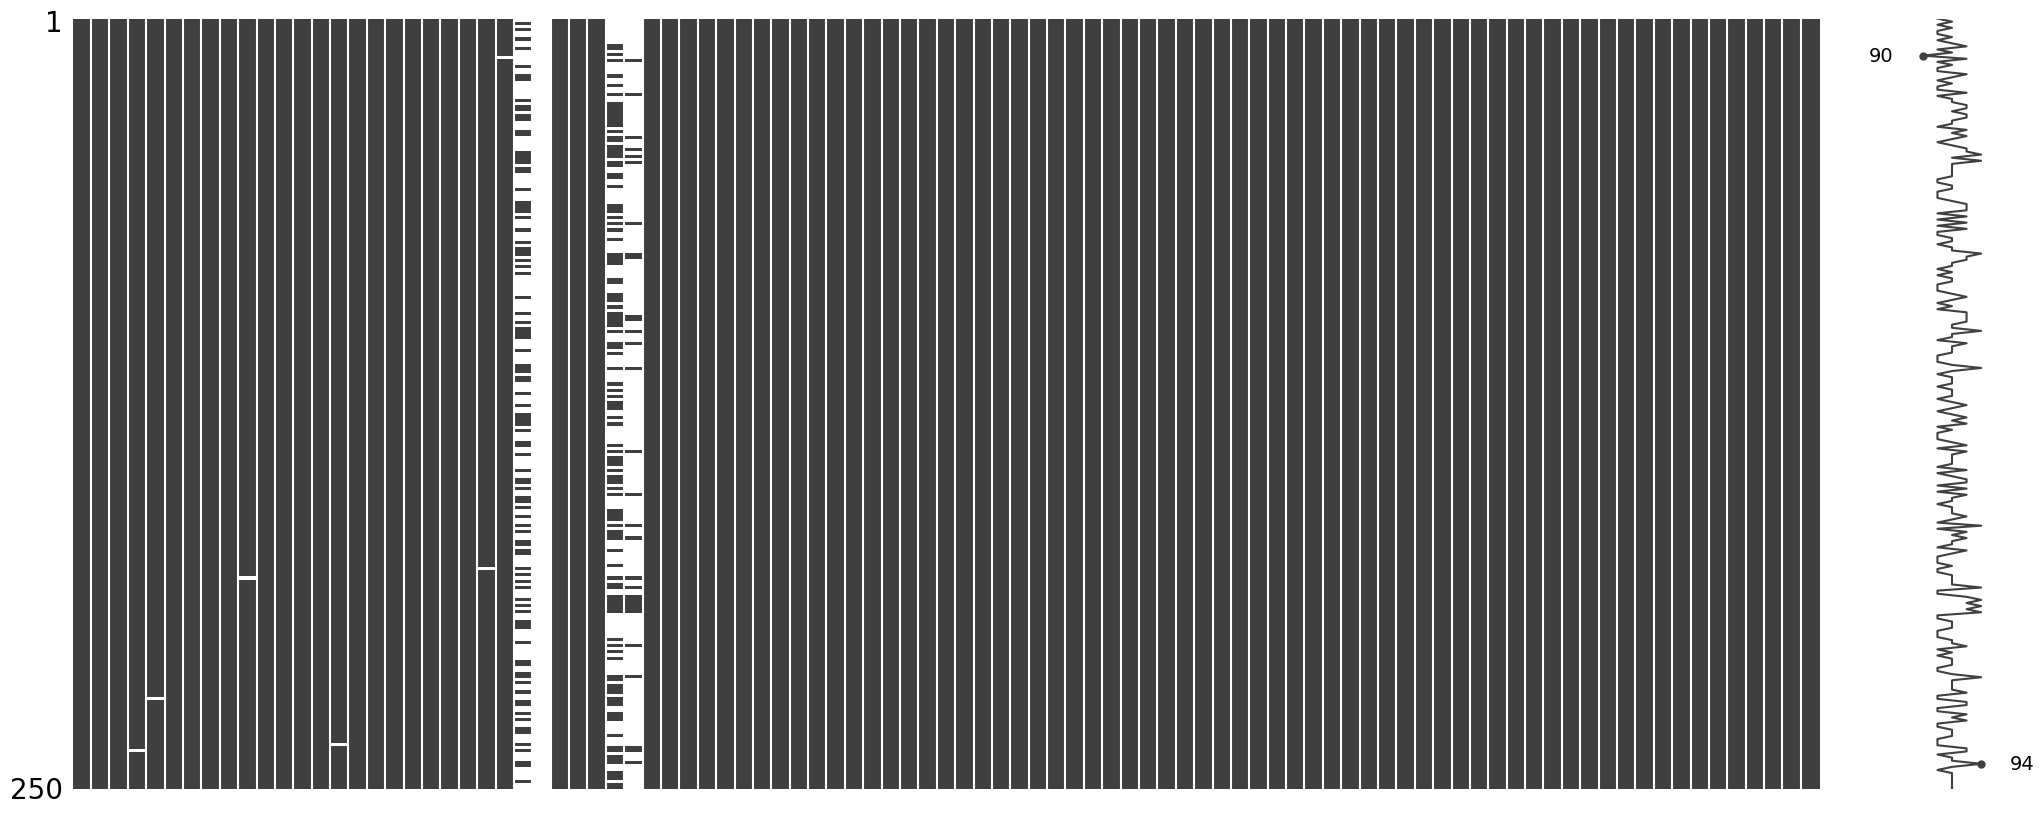

In [8]:
import missingno as msno
%matplotlib inline
msno.matrix(project_data.sample(250))